In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
from abc import ABC, abstractmethod
from tqdm import tqdm
from scipy.stats import truncnorm, invgamma

# sns.set(palette='viridis')
warnings.filterwarnings("ignore")

In [2]:
class BaseEstimatorClass(ABC):

    def __init__(self, price_series, cost_of_carry: float = 0.03, mu_prior: float = 0.0,
                 sigma_sq_mu_prior: float = 1.0, delta_t: float = 1.0):
        self.mu_prior = mu_prior
        self.sigma_sq_mu_prior = sigma_sq_mu_prior

        self.returns = np.diff(np.log(price_series))
        self.s0 = price_series[0]
        self.T = len(self.returns)
        self.delta_t = delta_t
        self.cost_of_carry = cost_of_carry

    @abstractmethod
    def Estimate(self, *args, **kwargs):
        pass

    @abstractmethod
    def get_paths(self, *args, **kwargs):
        pass

In [3]:
class HestonPosteriorParameters:

    @staticmethod
    def mu_star(psi, omega, kappa, theta, V, Y, Z, B, dt, mu_prior, sigma_sq_mu_prior):
        """ Posterior mean for the drift parameter"""
        numerator = sum((omega + psi ** 2) * (Y + 0.5 * V[:-2] * dt - Z * B) / (omega * V[:-2])) - \
                    sum(psi * (V[1:-1] - kappa * theta * dt - (1 - kappa * dt) * V[:-2]) / (omega * V[:-2])) \
                    + mu_prior / sigma_sq_mu_prior
        denominator = dt * sum((omega + psi ** 2) / (omega * V[:-2])) + 1 / sigma_sq_mu_prior
        return numerator / denominator

    @staticmethod
    def sigma_sq_star(psi, omega, V, dt, sigma_prior):
        """ Posterior variance for the drift parameter"""
        numerator = 1
        denominator = dt * sum((omega + psi ** 2) / (omega * V[:-2])) + 1 / (sigma_prior ** 2)
        return numerator / denominator

    @staticmethod
    def get_eps_s(V, Y, Z, B, mu, dt):
        return (Y - mu * dt + 0.5 * V[:-2] * dt - Z * B) / np.sqrt(V[:-2] * dt)

    @staticmethod
    def get_eps_v(V, dt, kappa, theta):
        return (V[1:-1] - kappa * theta * dt - (1 - kappa * dt) * V[:-2]) / np.sqrt(V[:-2] * dt)

    @classmethod
    def beta_star(cls, V, Y, Z, B, mu, dt, kappa, theta, beta_prior, p_prior, psi_prior):
        """ Posterior beta parameter for Omega which is
        used to parameterize the variance of variance and
        the correlation of the stock and variance processes"""
        eps_S = cls.get_eps_s(V, Y, Z, B, mu, dt)
        eps_V = cls.get_eps_v(V, dt, kappa, theta)
        result = beta_prior + 0.5 * sum(eps_V ** 2) + 0.5 * p_prior * psi_prior ** 2 - \
                 0.5 * ((p_prior * psi_prior + sum(eps_S * eps_V)) ** 2 / (p_prior + sum(eps_S ** 2)))
        return result

    @classmethod
    def psi_star(cls, Y, V, Z, B, mu, dt, kappa, theta, p_prior, psi_prior):
        """ Posterior mean parameter for psi which is also
        used to parameterize the variance of variance and
        the correlation of the stock and variance processes """
        eps_S = cls.get_eps_s(V, Y, Z, B, mu, dt)
        eps_V = cls.get_eps_v(V, dt, kappa, theta)
        result = (p_prior * psi_prior + sum(eps_S * eps_V)) / (p_prior + sum(eps_S ** 2))
        return result

    @classmethod
    def sigma_sq_psi_star(cls, Y, V, Z, B, mu, dt, p_prior, omega):
        """ Posterior variance parameter for psi which is used
        to parameterize the variance of variance and
        the correlation of the stock and variance processes """
        eps_S = cls.get_eps_s(V, Y, Z, B, mu, dt)
        result = omega / (p_prior + sum(eps_S ** 2))
        return result

    @staticmethod
    def theta_star(Y, V, Z, B, mu, dt, psi, kappa, omega, theta_prior, sigma_sq_theta_prior):
        """ Posterior mean parameter for the mean reversion parameter for
        the variance process """
        numerator = sum(kappa * (V[1:-1] - (1 - kappa * dt) * V[:-2]) / (omega * V[:-2])) - \
                    sum(psi * (Y - mu * dt + 0.5 * V[:-2] * dt - Z * B) * kappa / (omega * V[:-2]) +
                        theta_prior / sigma_sq_theta_prior)
        denominator = dt * sum(kappa ** 2 / (omega * V[:-2])) + 1 / sigma_sq_theta_prior
        theta = numerator / denominator
        return theta

    @staticmethod
    def sigma_sq_theta_star(V, dt, kappa, omega, sigma_sq_theta_prior):
        """ Posterior variance parameter for the mean reversion parameter for
        the variance process """
        denominator = dt * sum(kappa ** 2 / (omega * V[:-2])) + 1 / sigma_sq_theta_prior
        return 1 / denominator

    @staticmethod
    def kappa_star(Y, V, Z, B, mu, dt, psi, theta, omega, kappa_prior, sigma_sq_kappa_prior):
        """ Posterior mean parameter for the mean reversion rate parameter for
        the variance process """
        numerator = sum((theta - V[1:-1]) * (V[1:-1] - V[:-2]) / (omega * V[:-2])) - \
                    sum(psi * (Y - mu * dt + 0.5 * V[:-2] * dt - Z * B) * (theta - V[:-2]) / (omega * V[:-2])) + \
                    kappa_prior / sigma_sq_kappa_prior
        denominator = dt * sum((V[:-2] - theta) ** 2 / (omega * V[:-2])) + 1 / sigma_sq_kappa_prior
        return numerator / denominator

    @staticmethod
    def sigma_sq_kappa_star(V, dt, theta, omega, sigma_sq_kappa_prior):
        """ Posterior variance parameter for the mean reversion rate parameter for
        the variance process """
        denominator = dt * sum((V[:-2] - theta) ** 2 / (omega * V[:-2])) + 1 / sigma_sq_kappa_prior
        return 1 / denominator

    @staticmethod
    def mu_s_star(psi, omega, kappa, theta, V_t_minus_1, V_t, Y_t, mu, dt, mu_s, sigma_sq_s):
        """ Posterior mean for the jump size """
        numerator = ((omega + psi ** 2) * (Y_t + 0.5 * V_t_minus_1 * dt - mu * dt) / (omega * V_t_minus_1 * dt)) - \
                    (psi * (V_t - kappa * theta * dt - (1 - kappa * dt) * V_t_minus_1) / (omega * V_t_minus_1 * dt)) \
                    + mu_s / sigma_sq_s
        denominator = (omega + psi ** 2) / (omega * V_t_minus_1 * dt) + 1 / sigma_sq_s
        return numerator / denominator

    @staticmethod
    def sigma_sq_s_star(psi, omega, V_t_minus_1, dt, sigma_sq_s):
        """ Posterior variance for the jump size """
        denominator = (omega + psi ** 2) / (omega * V_t_minus_1 * dt) + 1 / sigma_sq_s
        return 1 / denominator

    @staticmethod
    def mu_m_s_star(S_0, sigma_sq_s, T, Z):
        """ Drift parameter"""
        numerator = sum(Z / sigma_sq_s)
        denominator = 1 / S_0 + T / sigma_sq_s
        return numerator / denominator

    @staticmethod
    def sigma_sq_m_s_star(S_0, sigma_sq_s, T):
        """ Volatility parameter"""
        denominator = 1 / S_0 + T / sigma_sq_s
        return 1 / denominator

    @staticmethod
    def get_p_star(psi, omega, kappa, theta, V_t_minus_1, V_t, Y_t, Z_t, mu_drift, delta_t, lambda_d):
        """ Correlation parameter"""
        A = ((omega + psi ** 2) * (
                Z_t ** 2 - 2 * Z_t * (Y_t - mu_drift * delta_t + 0.5 * V_t_minus_1 * delta_t)) + 2 * psi * (
                     V_t - kappa * theta * delta_t - (1 - kappa * delta_t) * V_t_minus_1) * Z_t) / (
                    omega * V_t_minus_1 * delta_t)
        denominator = (1 - lambda_d) * np.exp(0.5 * A) / lambda_d + 1
        return 1 / denominator

    @staticmethod
    def state_space_target_dist_term_1(V_proposed_or_current, Y_t_plus_1, Z_t_plus_1, B_t_plus_1,
                                       dt, mu, omega, psi):
        return (-1 / (2 * omega)) * (((omega + psi ** 2) * (
                0.5 * V_proposed_or_current * dt + Y_t_plus_1 - Z_t_plus_1 * B_t_plus_1 - mu * dt) ** 2) / (
                                             V_proposed_or_current * dt))

    @staticmethod
    def state_space_target_dist_term_2(V_proposed_or_current, Y_t_plus_1, V_t_plus_1, Z_t_plus_1, B_t_plus_1,
                                       dt, mu, omega, psi, kappa, theta):
        return (-1 / (2 * omega)) * (
                (-2 * psi * (0.5 * V_proposed_or_current * dt + Y_t_plus_1 - Z_t_plus_1 * B_t_plus_1 -
                             mu * dt) * (
                         (kappa * dt - 1) * V_proposed_or_current - kappa * theta * dt + V_t_plus_1)) / (
                        V_proposed_or_current * dt))

    @staticmethod
    def state_space_target_dist_term_3(V_proposed_or_current, V_t_plus_1, dt, omega, kappa, theta):
        return (-1 / (2 * omega)) * (
                ((kappa * dt - 1) * V_proposed_or_current - kappa * theta * dt + V_t_plus_1) ** 2 / (
                V_proposed_or_current * dt))

    @staticmethod
    def state_space_target_dist_term_4(V_proposed_or_current, Y_t, Z_t, B_t, V_t_minus_1,
                                       dt, mu, omega, psi, kappa, theta):
        return (-1 / (2 * omega)) * (
                -2 * psi * (Y_t - Z_t * B_t - mu * dt + 0.5 * V_t_minus_1 * dt) * (V_proposed_or_current -
                                                                                   kappa * theta * dt - (
                                                                                           1 - kappa * dt) * V_t_minus_1) / (
                        V_t_minus_1 * dt))

    @staticmethod
    def state_space_target_dist_term_5(V_proposed_or_current, V_t_minus_1, dt, omega, kappa, theta):
        return (-1 / (2 * omega)) * (
                (V_proposed_or_current - kappa * theta * dt - (1 - kappa * dt) * V_t_minus_1) ** 2 / (V_t_minus_1 * dt))

    @classmethod
    def state_space_target_dist_t_0(cls, V_proposed_or_current, Y_t_plus_1, V_t_plus_1, Z_t_plus_1, B_t_plus_1,
                                    dt, mu, omega, psi, kappa, theta):
        """ Formula for the target distribution of the state space """
        multiplier = 1 / (V_proposed_or_current * dt)
        term_1 = cls.state_space_target_dist_term_1(V_proposed_or_current, Y_t_plus_1, Z_t_plus_1, B_t_plus_1,
                                                    dt, mu, omega, psi)
        term_2 = cls.state_space_target_dist_term_2(V_proposed_or_current, Y_t_plus_1, V_t_plus_1, Z_t_plus_1,
                                                    B_t_plus_1,
                                                    dt, mu, omega, psi, kappa, theta)
        term_3 = cls.state_space_target_dist_term_3(V_proposed_or_current, V_t_plus_1, dt, omega, kappa, theta)
        return multiplier * np.exp(term_1 + term_2 + term_3)

    @classmethod
    def state_space_target_dist_t_1_to_T(cls, V_proposed_or_current, Y_t, Z_t, B_t, Y_t_plus_1, V_t_plus_1, V_t_minus_1,
                                         Z_t_plus_1, B_t_plus_1, dt, mu, omega, psi, kappa, theta):
        """ Formula for the target distribution of the state space """
        multiplier = 1 / (V_proposed_or_current * dt)
        term_1 = cls.state_space_target_dist_term_1(V_proposed_or_current, Y_t_plus_1, Z_t_plus_1, B_t_plus_1,
                                                    dt, mu, omega, psi)
        term_2 = cls.state_space_target_dist_term_2(V_proposed_or_current, Y_t_plus_1, V_t_plus_1, Z_t_plus_1,
                                                    B_t_plus_1,
                                                    dt, mu, omega, psi, kappa, theta)
        term_3 = cls.state_space_target_dist_term_3(V_proposed_or_current, V_t_plus_1, dt, omega, kappa, theta)
        term_4 = cls.state_space_target_dist_term_4(V_proposed_or_current, Y_t, Z_t, B_t, V_t_minus_1,
                                                    dt, mu, omega, psi, kappa, theta)
        term_5 = cls.state_space_target_dist_term_5(V_proposed_or_current, V_t_minus_1, dt, omega, kappa, theta)
        return multiplier * np.exp(term_1 + term_2 + term_3 + term_4 + term_5)

    @classmethod
    def state_space_target_dist_t_T_plus_1(cls, V_proposed_or_current, Y_t, Z_t, B_t, V_t_minus_1, dt,
                                           mu, omega, psi, kappa, theta):
        """ Formula for the target distribution of the state space """
        multiplier = 1 / (V_proposed_or_current * dt)
        term_4 = cls.state_space_target_dist_term_4(V_proposed_or_current, Y_t, Z_t, B_t, V_t_minus_1,
                                                    dt, mu, omega, psi, kappa, theta)
        term_5 = cls.state_space_target_dist_term_5(V_proposed_or_current, V_t_minus_1, dt, omega, kappa, theta)
        return multiplier * np.exp(term_4 + term_5)


In [4]:
class HestonModelEstimator(BaseEstimatorClass, HestonPosteriorParameters):

    def __init__(self, alpha_prior: float = 2.0, beta_prior: float = 0.005, p_prior: float = 2.0,
                 psi_prior: float = 0.0, theta_prior: float = 0.0, sigma_sq_theta_prior: float = 1.0,
                 kappa_prior: float = 0.0, sigma_sq_kappa_prior: float = 1.0, mu: float = 0.05,
                 kappa: float = 0.5, theta: float = 0.1, omega: float = 0.1, psi: float = 0,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initializing prior parameters
        self.alpha_prior = alpha_prior
        self.beta_prior = beta_prior
        self.p_prior = p_prior
        self.psi_prior = psi_prior
        self.theta_prior = theta_prior
        self.sigma_sq_theta_prior = sigma_sq_theta_prior
        self.kappa_prior = kappa_prior
        self.sigma_sq_kappa_prior = sigma_sq_kappa_prior
        self.alpha_star = self.T / 2 + self.alpha_prior
        # Iniitalizing posterior parameters
        self._mu = mu
        self._kappa = kappa
        self._theta = theta
        self._omega = omega
        self._psi = psi
        # Arrays for the parameters
        self._all_params_array_full = None
        self._all_params_array_no_burnin = None
        self._params_dict = None

    def Estimate(self, n_mcmc_steps=10000, burn_in=5000, rejection_rate=0.005):
        # Using a truncated normal distribution to get starting values of V
        V_t_array = np.array(truncnorm.rvs(a=0, b=np.inf, loc=0.0225, scale=0.005, size=self.T + 2))
        V_t_minus_1_array = np.roll(V_t_array, 1)
        V_t_minus_1_array[0] = 0
        V_t_plus_1_array = np.roll(V_t_array, -1)
        V_t_plus_1_array[-1] = 0

        Y_t_array = np.append(0, np.append(self.returns, 0))
        Y_t_plus_1_array = np.roll(Y_t_array, -1)
        Y_t_plus_1_array[-1] = 0

        self._all_params_array_full = np.zeros((n_mcmc_steps, len(V_t_array) + 5))
        self._all_params_array_full[0, 0:5] = np.array([self._mu, self._kappa, self._theta, self._psi, self._omega])
        self._all_params_array_full[0, 5:] = V_t_array

        zero_array = np.zeros((len(self.returns),))

        omega_alpha = self.alpha_star
        for iter in tqdm(range(1, n_mcmc_steps)):

            # Gibbs' sampling of model parameters. Start with the initialized parameters and update them using MCMC
            # Updating drift parameter
            mu_mean = self.mu_star(self._psi, self._omega, self._kappa, self._theta, V_t_array, self.returns,
                                   zero_array, zero_array, self.delta_t, self.mu_prior, self.sigma_sq_mu_prior)
            mu_variance = self.sigma_sq_star(self._psi, self._omega, V_t_array, self.delta_t, self.sigma_sq_mu_prior)
            self._mu = np.random.normal(mu_mean, np.sqrt(mu_variance))

            # Updating Omega
            omega_beta = self.beta_star(V_t_array, self.returns, zero_array, zero_array, self._mu, self.delta_t,
                                        self._kappa, self._theta, self.beta_prior, self.p_prior, self.psi_prior)
            self._omega = invgamma.rvs(omega_alpha, scale=omega_beta)

            # Updating psi
            psi_mean = self.psi_star(self.returns, V_t_array, zero_array, zero_array, self._mu, self.delta_t,
                                     self._kappa, self._theta, self.p_prior, self.psi_prior)
            psi_vola = np.sqrt(self.sigma_sq_psi_star(self.returns, V_t_array, zero_array, zero_array,
                                                      self._mu, self.delta_t, self.p_prior, self._omega))
            self._psi = np.random.normal(psi_mean, psi_vola)

            # Updating theta
            theta_mean = self.theta_star(self.returns, V_t_array, zero_array, zero_array, self._mu, self.delta_t,
                                         self._psi, self._kappa, self._omega, self.theta_prior,
                                         self.sigma_sq_theta_prior)
            theta_vola = np.sqrt(self.sigma_sq_theta_star(V_t_array, self.delta_t, self._kappa,
                                                          self._omega, self.sigma_sq_theta_prior))
            self._theta = truncnorm.rvs((0 - theta_mean) / theta_vola, (5 - theta_mean) / theta_vola, loc=theta_mean,
                                        scale=theta_vola)

            # Updating kappa
            kappa_mean = self.kappa_star(self.returns, V_t_array, zero_array, zero_array, self._mu, self.delta_t,
                                         self._psi, self._theta, self._omega, self.kappa_prior,
                                         self.sigma_sq_kappa_prior)
            kappa_vola = np.sqrt(self.sigma_sq_kappa_star(V_t_array, self.delta_t, self._theta,
                                                          self._omega, self.sigma_sq_kappa_prior))
            self._kappa = truncnorm.rvs((0 - kappa_mean) / kappa_vola, (5 - kappa_mean) / kappa_vola, loc=kappa_mean,
                                        scale=kappa_vola)

            # Using Metropolis-Hastings sampling of variance paths
            Y_and_V_arrays = zip(Y_t_array, Y_t_plus_1_array, V_t_minus_1_array, V_t_array, V_t_plus_1_array)
            V_t_array_new = list()
            for t, (Y_t, Y_t_plus_1, V_t_minus_1, V_t, V_t_plus_1) in enumerate(Y_and_V_arrays):

                # getting a proposal value from random normal
                V_proposal = np.random.normal(V_t, rejection_rate)

                # getting density of V at the previous and proposed values of V
                if t == 0:
                    V_density_at_curr = self.state_space_target_dist_t_0(V_t, Y_t_plus_1, V_t_plus_1, 0.0, 0.0,
                                                                         self.delta_t, self._mu, self._omega, self._psi,
                                                                         self._kappa, self._theta)
                    V_density_at_prop = self.state_space_target_dist_t_0(V_proposal, Y_t_plus_1, V_t_plus_1, 0.0, 0.0,
                                                                         self.delta_t, self._mu, self._omega, self._psi,
                                                                         self._kappa, self._theta)
                elif t != 0 and t <= len(self.returns):
                    V_density_at_curr = self.state_space_target_dist_t_1_to_T(V_t, Y_t, 0.0, 0.0, Y_t_plus_1,
                                                                              V_t_plus_1, V_t_minus_1, 0.0, 0.0,
                                                                              self.delta_t, self._mu, self._omega,
                                                                              self._psi, self._kappa, self._theta)
                    V_density_at_prop = self.state_space_target_dist_t_1_to_T(V_proposal, Y_t, 0.0, 0.0, Y_t_plus_1,
                                                                              V_t_plus_1, V_t_minus_1, 0.0, 0.0,
                                                                              self.delta_t, self._mu, self._omega,
                                                                              self._psi, self._kappa, self._theta)
                else:
                    V_density_at_curr = self.state_space_target_dist_t_T_plus_1(V_t, Y_t, 0.0, 0.0, V_t_minus_1,
                                                                                self.delta_t, self._mu, self._omega,
                                                                                self._psi, self._kappa, self._theta)
                    V_density_at_prop = self.state_space_target_dist_t_T_plus_1(V_proposal, Y_t, 0.0, 0.0, V_t_minus_1,
                                                                                self.delta_t, self._mu, self._omega,
                                                                                self._psi, self._kappa, self._theta)
                # Computing acceptance probability
                accept_prob = min(V_density_at_prop / V_density_at_curr, 1)
                u = np.random.uniform(0, 1)
                if u < accept_prob:
                    V_t = V_proposal
                V_t_array_new.append(V_t)
            # Updating vals
            V_t_array = np.array(V_t_array_new)
            V_t_minus_1_array = np.roll(V_t_array, 1)
            V_t_minus_1_array[0] = 0
            V_t_plus_1_array = np.roll(V_t_array, -1)
            V_t_plus_1_array[-1] = 0
            self._all_params_array_full[iter, 0:5] = np.array([self._mu, self._kappa, self._theta,
                                                               self._psi, self._omega])
            self._all_params_array_full[iter, 5:] = V_t_array_new
        self._all_params_array_no_burnin = self._all_params_array_full[burn_in:, :]
        mu_final = np.mean(self._all_params_array_no_burnin[:, 0])
        kappa_final = np.mean(self._all_params_array_no_burnin[:, 1])
        theta_final = np.mean(self._all_params_array_no_burnin[:, 2])
        psi_final = np.mean(self._all_params_array_no_burnin[:, 3])
        omega_final = np.mean(self._all_params_array_no_burnin[:, 4])
        rho_final = np.sqrt(1 / (1 + omega_final / (psi_final ** 2)))
        volvol_final = psi_final / rho_final
        if volvol_final < 0:
            rho_final = -rho_final
            volvol_final = psi_final / rho_final
        self._params_dict = {"mu_final": mu_final, "kappa_final": kappa_final, "theta_final": theta_final,
                             "volvol_final": volvol_final, "rho_final": rho_final}

    def get_paths(self, s0=100, nsteps=2000, nsim=100, risk_neutral=False):
        assert self._params_dict is not None, "Parameters have not been calibrated yet"
        mu = self._params_dict.get("mu_final")
        kappa = self._params_dict.get("kappa_final")
        theta = self._params_dict.get("theta_final")
        sigma = self._params_dict.get("volvol_final")
        rho = self._params_dict.get("rho_final")
        v0 = theta
        dt = 1 / nsteps
        simulated_paths = np.zeros([nsim, nsteps + 1])
        simulated_paths[:, 0] = s0
        simulated_volas = np.zeros([nsim, nsteps + 1])
        simulated_volas[:, 0] = v0

        # --- get randomness (correlated for each t=1,...,T, as corr(W_S, W_V) = rho)
        Z_V = np.random.normal(size=[nsim, nsteps + 1])
        Z_corr = np.random.normal(size=[nsim, nsteps + 1])
        Z_S = rho * Z_V + np.sqrt(1 - rho ** 2) * Z_corr

        # ----- generate paths
        for i in range(nsteps):
            # --- get the stochastic volatility component
            simulated_volas[:, i + 1] = simulated_volas[:, i] + kappa * (theta - simulated_volas[:, i]) * dt + \
                                        sigma * np.sqrt(simulated_volas[:, i]) * np.sqrt(dt) * Z_V[:, i + 1] + (
                                                0.5 ** 2) * (sigma ** 2) * dt * (Z_V[:, i + 1] ** 2 - 1)
            simulated_volas[:, i + 1] = list(map(lambda x: max(0, x), simulated_volas[:, i + 1]))

            # --- get drift with compensator
            if risk_neutral:
                drift = self.cost_of_carry - simulated_volas[:, i + 1] / 2
            else:
                drift = mu - simulated_volas[:, i + 1] / 2

            # --- get the total price dynamics
            simulated_paths[:, i + 1] = simulated_paths[:, i] * np.exp(
                drift * dt + np.sqrt(simulated_volas[:, i + 1] * dt) * Z_S[:, i + 1])
        return simulated_paths, simulated_volas

    @property
    def all_params_array_full(self):
        return self._all_params_array_full

    @property
    def all_params_array_no_burnin(self):
        return self._all_params_array_no_burnin

    @property
    def params_dict(self):
        return self._params_dict


In [5]:
# Getting the market data from csv
stock_data = pd.read_csv("apple_data.csv")["Adj Close"].values

# Initializing parameters
s0 = 100
nsteps = 2000
nsim = 100
r = 0.05
q = 0.02

In [10]:
# Setting MCMC parameters
n_mcmc_steps = 10000
burn_in = 5000
heston_estimator = HestonModelEstimator(price_series=stock_data, cost_of_carry=r - q)

start = time.time()
heston_estimator.Estimate(n_mcmc_steps=n_mcmc_steps, burn_in=burn_in)
finish = time.time()
print(f"{(finish-start)/60} minutes elapsed")

# Estimated parameters
all_params = heston_estimator.params_dict
mu = all_params.get("mu_final")
kappa = all_params.get("kappa_final")
theta = all_params.get("theta_final")
sigma = all_params.get("volvol_final")
rho = all_params.get("rho_final")

# Making paths for price and variance
simulated_paths, simulated_variances = heston_estimator.get_paths(s0=s0, nsteps=nsteps, nsim=nsim, risk_neutral=False)

100%|██████████| 9999/9999 [04:48<00:00, 34.64it/s]


4.811404852072398 minutes elapsed


The posterior parameters' dynamics is displayed in the figure below

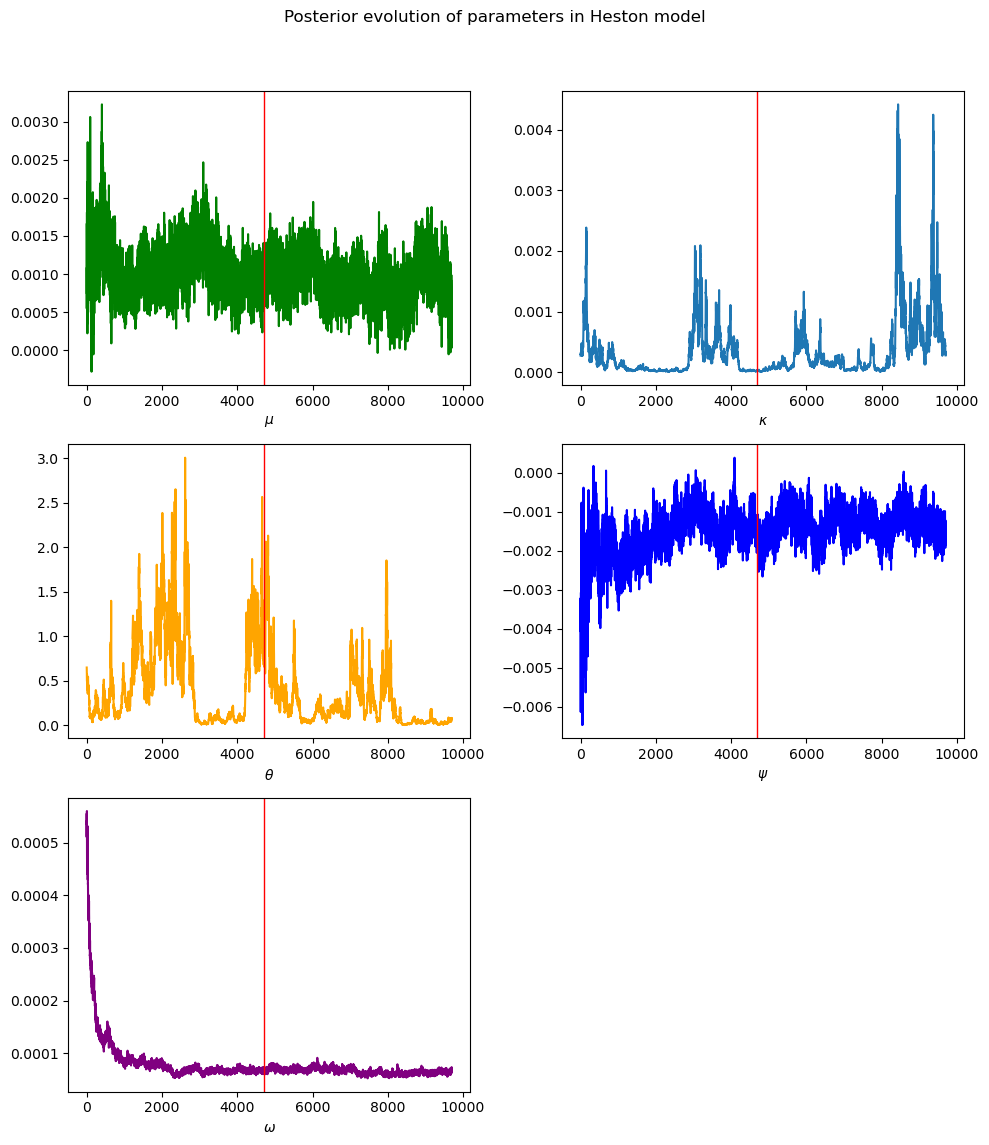

In [11]:
offset = 300
burn_in_pos = burn_in - offset
param_paths = heston_estimator.all_params_array_full[offset:, :]
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes[0, 0].plot(param_paths[:, 0], color="green")
axes[0, 0].axvline(x=burn_in_pos, color="red", linewidth=1)
axes[0, 0].set_xlabel("$\\mu$")
axes[0, 1].plot(param_paths[:, 1])
axes[0, 1].axvline(x=burn_in_pos, color="red", linewidth=1)
axes[0, 1].set_xlabel("$\\kappa$")
axes[1, 0].plot(param_paths[:, 2], color="orange")
axes[1, 0].axvline(x=burn_in_pos, color="red", linewidth=1)
axes[1, 0].set_xlabel("$\\theta$")
axes[1, 1].plot(param_paths[:, 3], color="blue")
axes[1, 1].axvline(x=burn_in_pos, color="red", linewidth=1)
axes[1, 1].set_xlabel("$\\psi$")
axes[2, 0].plot(param_paths[:, 4], color="purple")
axes[2, 0].axvline(x=burn_in_pos, color="red", linewidth=1)
axes[2, 0].set_xlabel("$\\omega$")
axes[2, 1].remove()
plt.suptitle('Posterior evolution of parameters in Heston model')
plt.subplots_adjust(wspace=None, hspace=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Also get the simulated stock price paths

Text(0, 0.5, 'Stock price')

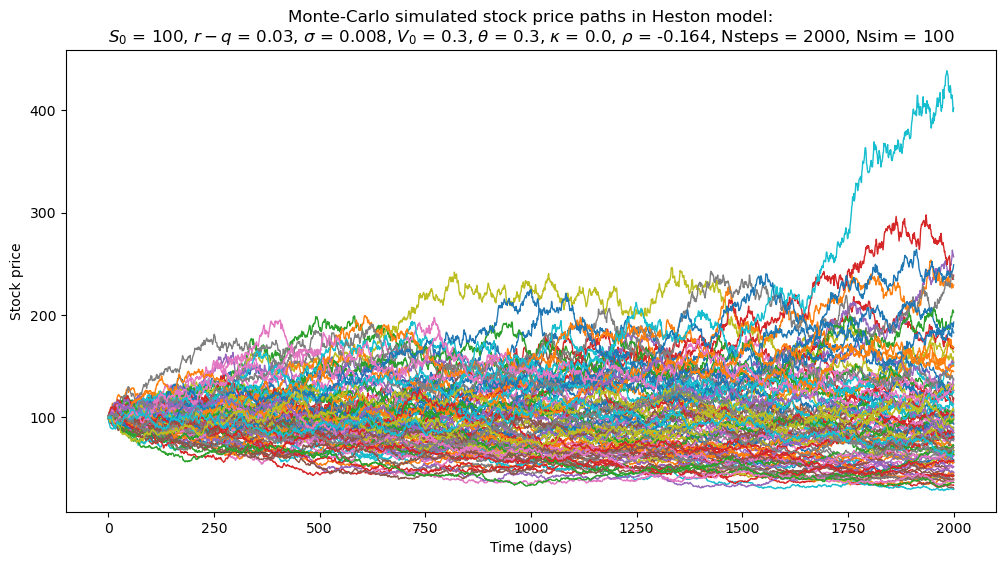

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps
bates_prices = ax.plot(days, simulated_paths.transpose(), linewidth=1)
ax.set_title("Monte-Carlo simulated stock price paths in Heston model:\n$S_0$ = {}, $r-q$ = {}, "
             "$\\sigma$ = {}, $V_0$ = {}, $\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, "
             "Nsteps = {}, Nsim = {}".format(*list(map(lambda x: round(x, 3), [s0, r - q, np.round(sigma, 3),
                                                                               np.round(theta, 3), np.round(theta, 3),
                                                                               np.round(kappa, 3), np.round(rho, 3),
                                                                               nsteps, nsim]))))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Stock price')

And the simulated variance paths

Text(0, 0.5, 'Variance process')

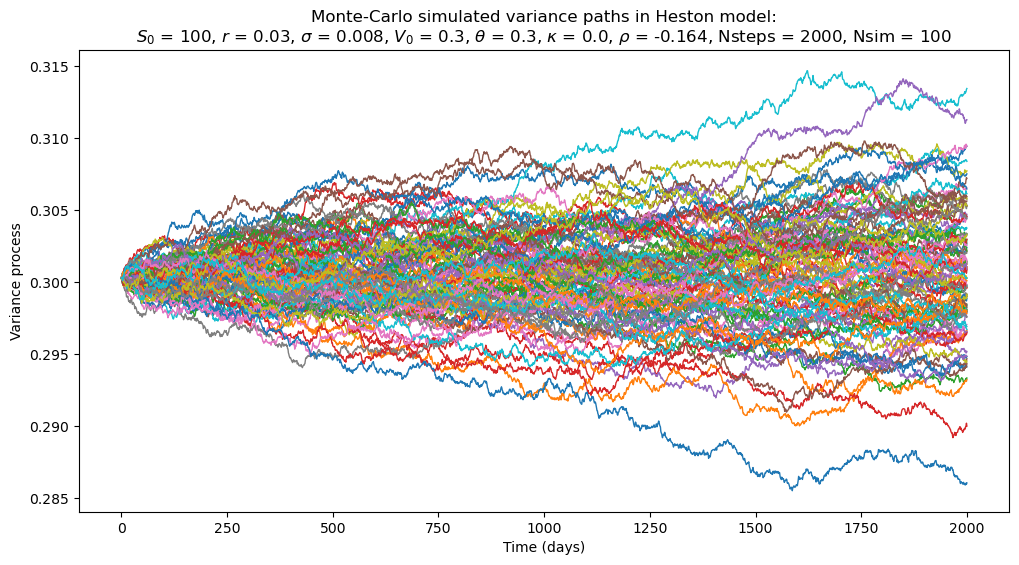

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps
bates_volas = ax.plot(days, simulated_variances.transpose(), linewidth=1)
ax.set_title("Monte-Carlo simulated variance paths in Heston model:\n$S_0$ = {}, $r$ = {}, "
             "$\\sigma$ = {}, $V_0$ = {}, $\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, "
             "Nsteps = {}, Nsim = {}".format(*list(map(lambda x: round(x, 3), [s0, r - q, np.round(sigma, 3),
                                                                               np.round(theta, 3), np.round(theta, 3),
                                                                               np.round(kappa, 3), np.round(rho, 3),
                                                                               nsteps, nsim]))))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Variance process')